In [1]:
import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler

import tensorflow as tf

In [2]:
config = {
        # Arquitectura
        "result_name": "lstm_5q_mean",
        "lstm_units_1": 64,
        "lstm_units_2": 32,
        "dense_units": 16,
        "dropout_rate": 0.3,
        "seed": 42,  # Para reproducibilidad
        # Entrenamiento
        "epochs": 150,
        "batch_size": 64,
        "early_stopping_patience": 30,
        "learning_rate": None,  # Si querés usar Adam con tasa específica

        # Regularización
        "l2_lambda": 0.001,

        # Optimizador
        "optimizer": "rmsprop",  # adam, sgd, rmsprop, etc.

        # Preprocesamiento
        "scaler_name": "robust",  # standard o robust

        # Ventana temporal
        "window_size": 6,
        "feature_cols" : ['tn', 
                          
                          #'tn_lag1', 
                          #'tn_lag6', 
                          #'tn_lag12', 
                          #'tn_diff1', 
                          #'tn_diff6',
                        #'rolling_mean6', 
                        #'rolling_std6', 
                        # 'rolling_max3', 
                        # 'rolling_min3',
                        # 'rolling_max6',
                        # 'rolling_min6',
                        #"size"
                        #"quantil_std",
                        #"sin_mes",
                        "quarter",
                        "month"
                        ],
        "products_to_train": None,  # Filtrar productos entre 50 y 150
    }


In [3]:
df = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")

productos_ok = pd.read_csv("https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/product_id_apredecir201912.txt", sep="\t")

df = df[df["product_id"].isin(productos_ok["product_id"])]

periodos = df["periodo"].unique()
ultimos_6_meses = list(periodos[-6:])
std6 = df.query("periodo in @ultimos_6_meses").groupby("product_id")["tn"].std().reset_index().fillna(0)
std6.columns = ["product_id", "std6"]
std6.sort_values(by="std6", ascending=False, inplace=True)
std6["grupo"] = pd.qcut(std6["std6"], 5, labels=False)
productos = list(df["product_id"].unique())
productos.sort()
# Filtrar productos entre 50 y 150
max_std = std6["grupo"].max()
#std6.loc[std6["product_id"].isin(productos[:50]), "grupo"] = max_std + 1  # Asegurar que los productos filtrados tengan un quantil distinto
grupo_dict = {int(r.product_id): int(r.grupo) for i, r in std6.iterrows()}



In [4]:
# import pandas as pd

# df = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")

# # Seleccionar los últimos 6 meses (ajusté a 6 como en el nombre de la variable, aunque tu lista tenía 12)
# periodos = df["periodo"].unique()
# ultimos_6_meses = list(periodos[-6:])  # Cambiado a 6 para coincidir con el nombre

# # Calcular media y desviación estándar para cada producto
# stats_6 = df.query("periodo in @ultimos_6_meses").groupby("product_id")["tn"].agg(['std', 'mean']).reset_index().fillna(0)

# # Calcular coeficiente de variación (en porcentaje)
# stats_6['cv'] = (stats_6['std'] / stats_6['mean']) * 100
# # Manejar casos donde la media es 0 (cv infinito)
# stats_6['cv'] = stats_6['cv'].replace([float('inf'), -float('inf')], 0)

# # Ordenar por CV
# stats_6.sort_values(by="cv", ascending=False, inplace=True)

# # Crear quantiles basados en el CV
# stats_6["quantil_cv"] = pd.qcut(stats_6["cv"], 5, labels=False) 

# # Crear el diccionario final
# cv_dict = {int(r.product_id): int(r.quantil_cv) for i, r in stats_6.iterrows()}

In [5]:
# Cargar de nuevo por claridad

# Agrupar y sumar las toneladas por producto y período
df_grouped = df.groupby(["product_id", "periodo"]).agg({"tn": "sum"}).reset_index()

# Calcular el total de toneladas por período
total_por_periodo = df_grouped.groupby("periodo")["tn"].transform("sum")

# Calcular la ponderación (porcentaje) de cada producto respecto al total de su período
df_grouped["tn"] = (df_grouped["tn"] / total_por_periodo) * 100

# Opcional: redondear los resultados para mejor presentación
df_grouped["tn"] = df_grouped["tn"].round(2)


# Encontrar el primer período para cada producto
min_periods = df_grouped.groupby("product_id")["periodo"].min().reset_index()

# Crear todas las combinaciones relevantes
all_periods = df_grouped["periodo"].unique()
all_periods.sort()

# Usar un merge cartesiano con filtro posterior
df = (
    min_periods.merge(pd.DataFrame({"periodo": all_periods}), how="cross")
    .query("periodo_y >= periodo_x")
    .drop(columns="periodo_x")
    .rename(columns={"periodo_y": "periodo"})
    .merge(df_grouped, on=["product_id", "periodo"], how="left")
    .fillna(0)
    .sort_values(["product_id", "periodo"])
    .reset_index(drop=True)
)

In [6]:


# Agregación mensual por producto
# df = df.groupby(["product_id", "periodo"]).agg({"tn": "sum"}).sort_values(["product_id", "periodo"]).reset_index()
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")

# Crear características por producto
def agregar_features(df):
    df = df.copy()
    df = df.sort_values(["product_id", "periodo"])
    # quantil de la desviación estándar de los últimos 6 meses
    df["grupo"] = df.product_id.map(grupo_dict).fillna(0)
    df["grupo"] = df["grupo"].astype(int)
    # Crear features con groupby + transform
    df["tn_lag1"] = df.groupby("product_id")["tn"].shift(1)
    #df["tn_lag6"] = df.groupby("product_id")["tn"].shift(6)
    #df["tn_lag12"] = df.groupby("product_id")["tn"].shift(12)

    df["tn_diff1"] = df["tn"] - df["tn_lag1"]
    #df["tn_diff6"] = df["tn"] - df["tn_lag6"]
    #df["size"] = df.groupby("product_id")["tn"].transform("size")
    
    df["sin_mes"] = df["periodo"].dt.month.apply(lambda x: np.sin(2 * np.pi * x / 12))
    df["quarter"] = df["periodo"].dt.quarter
    df["month"] = df["periodo"].dt.month

    df["rolling_mean6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).mean())
    df["rolling_std6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).std())
    
    # df["rolling_max3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).max())
    # df["rolling_min3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).min())
    # df["rolling_max6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).max())
    # df["rolling_min6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).min())

    return df

df_features = agregar_features(df).fillna(0)
df = df_features.copy()
print(df_features.shape)

(22375, 11)


In [7]:
df_features

,product_id,periodo,tn,grupo,tn_lag1,tn_diff1,sin_mes,quarter,month,rolling_mean6,rolling_std6
0,20001,2017-01-01,3.44,4,0.00,0.00,5.000000e-01,1,1,0.0,0.0
1,20001,2017-02-01,2.92,4,3.44,-0.52,8.660254e-01,1,2,0.0,0.0
2,20001,2017-03-01,3.56,4,2.92,0.64,1.000000e+00,1,3,0.0,0.0
3,20001,2017-04-01,3.44,4,3.56,-0.12,8.660254e-01,2,4,0.0,0.0
4,20001,2017-05-01,4.20,4,3.44,0.76,5.000000e-01,2,5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
22370,21276,2019-08-01,0.00,0,0.00,0.00,-8.660254e-01,3,8,0.0,0.0
22371,21276,2019-09-01,0.00,0,0.00,0.00,-1.000000e+00,3,9,0.0,0.0
22372,21276,2019-10-01,0.00,0,0.00,0.00,-8.660254e-01,4,10,0.0,0.0
22373,21276,2019-11-01,0.00,0,0.00,0.00,-5.000000e-01,4,11,0.0,0.0


In [8]:
# Último período disponible
ultimo_mes = df_features["periodo"].max()

# Definir los 3 meses anteriores
ultimos_3_meses = pd.date_range(end=ultimo_mes - pd.DateOffset(months=1), periods=3, freq='MS')

# Filtrar productos con datos en al menos 3 de esos meses
df_filtrado = df_features[df_features["periodo"].isin(ultimos_3_meses)]

# Contar cuántos meses tiene cada producto
conteo_por_producto = df_filtrado[df_filtrado["tn"] > 0].groupby("product_id").size()

# Seleccionar productos válidos
productos_validos = conteo_por_producto[conteo_por_producto >= 3].index

# Filtrar el dataframe original
df_features = df_features[df_features["product_id"].isin(productos_validos)].copy()
print(df_features.shape)

(16548, 11)


In [9]:
df_test = df_features[df_features["periodo"] == pd.to_datetime(201912, format="%Y%m")].copy()
df_features[df_features["periodo"].isin(pd.to_datetime([201911, 201912], format="%Y%m")) ]

,product_id,periodo,tn,grupo,tn_lag1,tn_diff1,sin_mes,quarter,month,rolling_mean6,rolling_std6
34,20001,2019-11-01,4.35,4,4.47,-0.12,-5.000000e-01,4,11,4.833333,0.676806
35,20001,2019-12-01,5.98,4,4.35,1.63,-2.449294e-16,4,12,4.681667,0.663910
70,20002,2019-11-01,4.43,4,5.67,-1.24,-5.000000e-01,4,11,3.690000,0.979959
71,20002,2019-12-01,4.32,4,4.43,-0.11,-2.449294e-16,4,12,3.871667,1.002864
106,20003,2019-11-01,2.95,4,3.10,-0.15,-5.000000e-01,4,11,2.505000,0.475258
...,...,...,...,...,...,...,...,...,...,...,...
20405,20995,2019-12-01,0.01,1,0.01,0.00,-2.449294e-16,4,12,0.000000,0.000000
20508,21007,2019-11-01,0.01,1,0.01,0.00,-5.000000e-01,4,11,0.000000,0.000000
20509,21007,2019-12-01,0.01,1,0.01,0.00,-2.449294e-16,4,12,0.008333,0.004082
20805,21035,2019-11-01,0.01,0,0.01,0.00,-5.000000e-01,4,11,0.000000,0.000000


In [10]:
# ================================
# 2. SCALING Y VENTANAS TEMPORALES
# ================================

window_size = config["window_size"]

def get_window_size(q):
  window_size = 3 if q >= 3 else 6
  return window_size

scaler_name = config["scaler_name"]

feature_cols = config["feature_cols"]

# Agrupar por producto
productos = df_features["product_id"].unique()
productos = list(productos)
scalers = {}  # Guardamos los scalers por producto


In [11]:

# ================================
# 3. TRAIN / TEST SPLIT
# ================================
from sklearn.model_selection import train_test_split
grupos = df_features["grupo"].unique()
grupos.sort()
sets = {}
modelos = {}
metricas = {}
seed = config.get("seed", 42)
for grupo in grupos:
    window_size = get_window_size(grupo)
    df_grupo = df_features[df_features["grupo"] == grupo].copy()
    sets[grupo] = {}
    X, y, productos_list = [], [], []
    periodos = []
    productos_train = df_grupo["product_id"].unique()
    
    for producto in productos_train:
        df_prod = df_features[df_features["product_id"] == producto].copy()
        df_prod = df_prod.sort_values('periodo')
        if len(df_prod) < window_size + 2:
            continue

        scaler = StandardScaler() if scaler_name == "standard" else RobustScaler()
        scaled_features = scaler.fit_transform(df_prod[feature_cols])
        scalers[producto] = scaler

        for i in range(window_size, len(df_prod) - 2):
            X.append(scaled_features[i - window_size:i])
            y.append(scaled_features[i][0])
            productos_list.append(producto)
            periodo_target = df_prod.iloc[i + 2]["periodo"]
            periodos.append(periodo_target)
    

    
    
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    productos_list = np.array(productos_list)
    periodos = np.array(periodos)

    # Ahora sí, aplicá las máscaras
    train_mask = periodos <= pd.to_datetime("2019-09-30")
    test_mask = periodos == pd.to_datetime("2019-10-01")

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    productos_test = productos_list[test_mask]
    
    sets[grupo]["X"] = X
    sets[grupo]["y"] = y
    sets[grupo]["X_train"] = X_train
    sets[grupo]["X_test"] = X_test
    sets[grupo]["y_train"] = y_train
    sets[grupo]["y_test"] = y_test
    sets[grupo]["productos_train"] = productos_train
    print(f"grupo {grupo}: {len(productos_train)} productos, {len(X_train)} muestras de entrenamiento, {len(X_test)} muestras de test")
    
    
    
# ================================


grupo 0: 16 productos, 347 muestras de entrenamiento, 15 muestras de test
grupo 1: 96 productos, 1708 muestras de entrenamiento, 77 muestras de test
grupo 2: 140 productos, 2418 muestras de entrenamiento, 116 muestras de test
grupo 3: 152 productos, 3307 muestras de entrenamiento, 146 muestras de test
grupo 4: 154 productos, 3749 muestras de entrenamiento, 146 muestras de test


In [12]:

# ================================
# 4. MODELO LSTM
# ================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

tf.random.set_seed(seed)

def custom_mape_loss(y_true, y_pred):
    """
    Pérdida personalizada: Mean Absolute Percentage Error (MAPE) modificado
    donde el denominador es la suma total de los valores reales.
    """
    numerator = tf.reduce_sum(tf.abs(y_true - y_pred))
    denominator = tf.reduce_sum(tf.abs(y_true))
    return numerator / (denominator + tf.keras.backend.epsilon())  # Evita división por cero

for grupo in sets:
    window_size = get_window_size(grupo)
    set_data = sets[grupo]
    X_train = set_data["X_train"]
    y_train = set_data["y_train"]
    X_test = set_data["X_test"]
    y_test = set_data["y_test"]
    
    
    
    l2_lambda = config["l2_lambda"]
    optimizer = config["optimizer"]
    epochs = config["epochs"]
    batch_size = config["batch_size"]
    early_stopping_patience = config["early_stopping_patience"]

    def get_reg(l2_lambda):
        return l2(l2_lambda) if l2_lambda > 0 else None

    n_features = X.shape[2]
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(window_size, n_features)),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(32, activation='relu', kernel_regularizer=get_reg(l2_lambda)),
        Dense(1)
    ])

    model.compile(optimizer=optimizer, loss=custom_mape_loss, metrics=custom_mape_loss)

    callbacks = [
         EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.1, patience=15)
    ]

    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1,
    )
    modelos[grupo] = model
    # Evaluar el modelo
    
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    metricas[grupo] = {
        "loss": loss,
        "mae": mae
    }

Epoch 1/150
6/6 [==============================] - 9s 308ms/step - loss: 1.0605 - custom_mape_loss: 1.0346 - val_loss: 1.0451 - val_custom_mape_loss: 1.0163 - lr: 0.0010
Epoch 2/150
6/6 [==============================] - 0s 32ms/step - loss: 1.0441 - custom_mape_loss: 1.0148 - val_loss: 1.0367 - val_custom_mape_loss: 1.0088 - lr: 0.0010
Epoch 3/150
6/6 [==============================] - 0s 32ms/step - loss: 1.0332 - custom_mape_loss: 1.0060 - val_loss: 1.0388 - val_custom_mape_loss: 1.0118 - lr: 0.0010
Epoch 4/150
6/6 [==============================] - 0s 32ms/step - loss: 1.0387 - custom_mape_loss: 1.0109 - val_loss: 1.0266 - val_custom_mape_loss: 1.0005 - lr: 0.0010
Epoch 5/150
6/6 [==============================] - 0s 31ms/step - loss: 1.0326 - custom_mape_loss: 1.0105 - val_loss: 1.0370 - val_custom_mape_loss: 1.0117 - lr: 0.0010
Epoch 6/150
6/6 [==============================] - 0s 31ms/step - loss: 1.0333 - custom_mape_loss: 1.0077 - val_loss: 1.0309 - val_custom_mape_loss: 1.006

In [13]:
# ================================
# 5. PREDICCIÓN t+2
# ================================

def predecir_t2(product_id, df_features_full):
    """
    product_id: ID del producto a predecir.
    df_features_full: dataframe con las features ya procesadas.
    """
    df_prod = df_features_full[df_features_full["product_id"] == product_id].copy()
    scaler = scalers[product_id]

    ultimos = df_prod[feature_cols].iloc[-window_size:]
    ultimos_scaled = scaler.transform(ultimos)

    X_new = ultimos_scaled.reshape(1, window_size, len(feature_cols))
    y_pred_scaled = model.predict(X_new)

    # Inversión del escalado solo sobre la primera columna (tn)
    tn_mean = scaler.center_[0]
    tn_std = scaler.scale_[0]

    y_pred = y_pred_scaled[0][0] * tn_std + tn_mean
    return y_pred

In [14]:
def predecir_todos_t2(df_features_full, scalers, feature_cols):
    """
    Predice tn en t+2 para todos los productos que tengan suficientes datos.

    Args:
        df_features_full (pd.DataFrame): dataframe completo con features
        model: modelo LSTM ya entrenado
        scalers (dict): diccionario con los StandardScaler por producto
        feature_cols (list): lista de columnas de features
        window_size (int): tamaño de la ventana temporal

    Returns:
        pd.DataFrame: dataframe con columnas ["product_id", "tn_t2_pred"]
    """
    productos = df_features_full["product_id"].unique()
    resultados = []
    errores = []
    for pid in productos:
        y_pred = None
        df_prod = df_features_full[df_features_full["product_id"] == pid]
        grupo = df_prod["grupo"].iloc[0] if not df_prod.empty else 0
        window_size = get_window_size(grupo)
        if len(df_prod) < window_size:
            y_pred = np.mean(df_prod["tn"][-12:])  # Valor por defecto si falla la predicción
            resultados.append({"product_id": pid, "tn_t2_pred": y_pred})
            continue  # no hay suficientes datos

        try:
            ultimos = df_prod[feature_cols].iloc[-window_size:]
            scaler = scalers[pid]
            ultimos_scaled = scaler.transform(ultimos)

            X_new = ultimos_scaled.reshape(1, window_size, len(feature_cols))
            model = modelos[int(df_prod["grupo"].iloc[0])]  # Obtener el modelo según el quantil
            y_pred_scaled = model.predict(X_new, verbose=0)

            # Desescalar
            tn_mean = scaler.center_[0]
            tn_std = scaler.scale_[0]
            y_pred = y_pred_scaled[0][0] * tn_std + tn_mean

            

        except Exception as e:
            errores.append(pid)
            #print(f"Error al predecir producto {pid}: {e}")
            
        if y_pred is None or y_pred < 0:
            y_pred = np.mean(df_prod["tn"][-12:])  # Valor por defecto si falla la predicción

            
        resultados.append({"product_id": pid, "tn_t2_pred": y_pred})

    print(f"Errores en predicciones: {errores} de {len(productos)} productos")
    return pd.DataFrame(resultados), errores





In [15]:
df_preds_t2, errores = predecir_todos_t2(
    df_features_full=df_features,
    scalers=scalers,
    feature_cols=feature_cols,
    #window_size=window_size
)
print(f"Errores: {len(errores)} de {len(df_features['product_id'].unique())} productos")
print(df_preds_t2.head())

Errores en predicciones: [20127, 20210, 20621, 20662, 20673, 20711, 20720, 20732, 20774, 20827, 20904, 20910, 20912, 20927, 20933, 21007, 21035] de 558 productos
Errores: 17 de 558 productos
   product_id  tn_t2_pred
0       20001    5.093401
1       20002    3.630157
2       20003    3.209207
3       20004    2.110017
4       20005    1.961916


In [16]:
df_preds_t2

,product_id,tn_t2_pred
0,20001,5.093401
1,20002,3.630157
2,20003,3.209207
3,20004,2.110017
4,20005,1.961916
...,...,...
553,20968,0.010000
554,20975,0.012500
555,20995,0.012500
556,21007,0.008571


In [17]:
dforig = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")
total_diciembre = dforig.query("periodo == 201912")["tn"].sum()
df_preds_t2["tn_t2_pred"] = df_preds_t2["tn_t2_pred"]

In [18]:
df_final = df_test.merge(df_preds_t2, on="product_id", how="left")
df_final

,product_id,periodo,tn,grupo,tn_lag1,tn_diff1,sin_mes,quarter,month,rolling_mean6,rolling_std6,tn_t2_pred
0,20001,2019-12-01,5.98,4,4.35,1.63,-2.449294e-16,4,12,4.681667,0.663910,5.093401
1,20002,2019-12-01,4.32,4,4.43,-0.11,-2.449294e-16,4,12,3.871667,1.002864,3.630157
2,20003,2019-12-01,3.55,4,2.95,0.60,-2.449294e-16,4,12,2.680000,0.394360,3.209207
3,20004,2019-12-01,2.54,4,2.25,0.29,-2.449294e-16,4,12,2.255000,0.466122,2.110017
4,20005,2019-12-01,2.36,4,1.89,0.47,-2.449294e-16,4,12,2.481667,0.386130,1.961916
...,...,...,...,...,...,...,...,...,...,...,...,...
553,20968,2019-12-01,0.01,1,0.01,0.00,-2.449294e-16,4,12,0.000000,0.000000,0.010000
554,20975,2019-12-01,0.01,1,0.01,0.00,-2.449294e-16,4,12,0.000000,0.000000,0.012500
555,20995,2019-12-01,0.01,1,0.01,0.00,-2.449294e-16,4,12,0.000000,0.000000,0.012500
556,21007,2019-12-01,0.01,1,0.01,0.00,-2.449294e-16,4,12,0.008333,0.004082,0.008571


In [19]:
numerador = (df_final["tn"]- df_final["tn_t2_pred"]).abs().sum()
denominador = df_final["tn"].sum()
porcentaje_error = (numerador / denominador)
porcentaje_error

0.23342133285724606

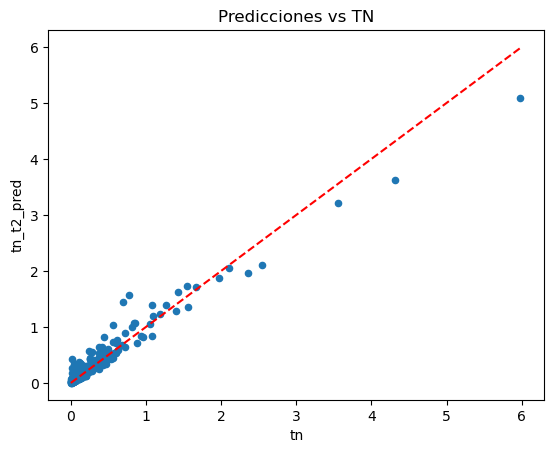

In [20]:
import matplotlib.pyplot as plt
df_final.plot(kind="scatter", x="tn", y="tn_t2_pred", title="Predicciones vs TN")
plt.plot([0, 6], [0, 6], 'r--')
plt.show()

In [23]:
import plotly.graph_objects as go

# Crear el gráfico de dispersión
fig = go.Figure()

# Añadir los puntos de dispersión con el product_id en el hover
fig.add_trace(go.Scatter(
    x=df_final["tn"],
    y=df_final["tn_t2_pred"],
    mode='markers',
    name='Datos',
    customdata=df_final["product_id"],  # Pasamos el product_id como dato adicional
    hovertemplate=(
        "<b>TN Real</b>: %{x}<br>"
        "<b>TN Predicho</b>: %{y}<br>"
        "<b>Product ID</b>: %{customdata}<br>"
        "<extra></extra>"  # Elimina información adicional automática
    ),
    marker=dict(size=8, opacity=0.7)  # Opcional: ajustar tamaño y transparencia
))

# Añadir la línea de referencia y=x
fig.add_trace(go.Scatter(
    x=[0, 1400],
    y=[0, 1400],
    mode='lines',
    name='y = x',
    line=dict(color='red', dash='dash')
))

# Configurar el diseño del gráfico para que sea cuadrado
fig.update_layout(
    title='Predicciones vs TN',
    xaxis_title='TN Real',
    yaxis_title='TN Predicho',
    showlegend=True,
    # Forzar misma escala en ejes X e Y
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1),
    # Tamaño cuadrado (opcional)
    width=600,
    height=600,
    # Rango fijo para ambos ejes (opcional)
    xaxis_range=[0, 7],
    yaxis_range=[0, 7]
)

# Mostrar el gráfico
fig.show()

In [21]:
print(df_final["tn_t2_pred"].sum(),"|",df_final["tn"].sum())

108.16608214931304 | 99.19


In [24]:
df_final["error"] = (df_final["tn"] - df_final["tn_t2_pred"]).abs()
df_final["error_relativo"] = df_final["error"] / df_final["tn"]
df_final.sort_values(by="error", ascending=False, inplace=True)
df_final[["product_id" ,"tn", "tn_t2_pred", "error", "error_relativo"]].head(20)


,product_id,tn,tn_t2_pred,error,error_relativo
0,20001,5.98,5.093401,0.886599,0.148261
7,20008,0.78,1.564094,0.784094,1.005248
11,20012,0.69,1.438787,0.748787,1.085199
1,20002,4.32,3.630157,0.689843,0.159686
17,20018,0.56,1.029048,0.469048,0.837585
3,20004,2.54,2.110017,0.429983,0.169285
502,20737,0.01,0.425452,0.415452,41.545162
4,20005,2.36,1.961916,0.398084,0.168680
27,20028,0.44,0.820971,0.380971,0.865844
2,20003,3.55,3.209207,0.340793,0.095998


In [25]:
sellin = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")

C:\Users\carre\AppData\Local\Temp\ipykernel_8168\1229155525.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



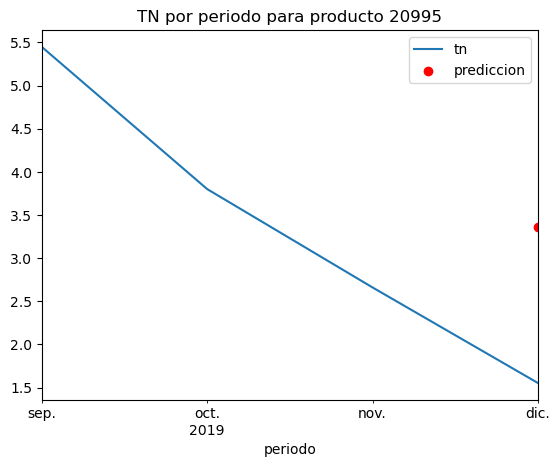

In [ ]:

prod = 20995
prod_s = sellin[sellin["product_id"] == prod]
prod_s["periodo"] = pd.to_datetime(prod_s["periodo"], format='%Y%m')
prod_s = prod_s.groupby("periodo").agg({"tn": "sum"}).reset_index()
#prod_s.plot(kind="line", x="periodo", y="tn", title="TN por periodo para producto 20002")

import matplotlib.pyplot as plt

ax = plt.gca()
prod_s.plot(kind="line", x="periodo", y="tn", title=f"TN por periodo para producto {prod}", ax=ax)
#plt.axhline(y=813.82, color='red', linestyle='--', label='predict')
prediccion = df_final[df_final["product_id"] == prod]["tn_t2_pred"].values[0]
plt.scatter(prod_s["periodo"].iloc[-1], prediccion, color='red', label='prediccion')
plt.legend()
plt.show()

In [26]:
df_final["volumen_cuartil"] = pd.qcut(df_final["tn"], q=10, labels=False)


In [27]:
print(df_final.groupby("volumen_cuartil")[["error"]].sum())

                    error
volumen_cuartil          
0                1.475759
1                0.852890
2                0.854710
3                0.786593
4                0.461755
5                0.653065
6                1.768342
7                2.749106
8                3.710746
9                9.840097


In [28]:
metricas

{0: {'loss': 1.0000289678573608, 'mae': 1.0000019073486328},
 1: {'loss': 31.48974609375, 'mae': 61.19758987426758},
 2: {'loss': 0.936298131942749, 'mae': 0.9527264833450317},
 3: {'loss': 1.0079106092453003, 'mae': 0.999066948890686},
 4: {'loss': 0.9290066957473755, 'mae': 0.937457263469696}}

In [29]:
df_preds_t2, errores = predecir_todos_t2(
    df_features_full=df,
    scalers=scalers,
    feature_cols=feature_cols,
    #window_size=window_size
)

Errores en predicciones: [20127, 20210, 20305, 20398, 20416, 20418, 20422, 20426, 20428, 20429, 20449, 20490, 20509, 20561, 20563, 20586, 20588, 20597, 20601, 20621, 20636, 20647, 20657, 20660, 20662, 20663, 20664, 20670, 20673, 20676, 20678, 20684, 20685, 20699, 20705, 20706, 20711, 20713, 20715, 20720, 20721, 20724, 20729, 20730, 20732, 20741, 20742, 20743, 20745, 20751, 20756, 20765, 20768, 20771, 20773, 20774, 20781, 20786, 20788, 20789, 20800, 20802, 20803, 20810, 20812, 20817, 20818, 20824, 20826, 20827, 20828, 20830, 20835, 20838, 20840, 20843, 20845, 20846, 20847, 20849, 20852, 20855, 20863, 20864, 20865, 20870, 20877, 20878, 20879, 20882, 20883, 20885, 20886, 20892, 20894, 20901, 20904, 20906, 20910, 20912, 20913, 20914, 20919, 20922, 20925, 20927, 20928, 20931, 20933, 20936, 20937, 20941, 20947, 20948, 20949, 20953, 20956, 20957, 20961, 20965, 20966, 20967, 20970, 20976, 20982, 20985, 20986, 20987, 20990, 20991, 20994, 20996, 20997, 21001, 21003, 21006, 21007, 21008, 21014, 2

In [30]:
total_diciembre = sellin.query("periodo == 201912")["tn"].sum()

In [33]:
productos_ok = pd.read_csv("https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/product_id_apredecir201912.txt", sep="\t")

pred = pd.DataFrame({"product_id": df_preds_t2["product_id"],  "tn": df_preds_t2["tn_t2_pred"]})
pred["tn"] = pred["tn"] * total_diciembre/100
pred = pred[pred["product_id"].isin(productos_ok["product_id"])]
result_name = config["result_name"]
result_name = "LSTM_Q5_Share"
pred.to_csv(f"{result_name}.csv", sep=",", index=False)

In [32]:
pred

,product_id,tn
0,20001,1335.340496
1,20002,951.720780
2,20003,841.359907
3,20004,553.184467
4,20005,514.356908
...,...,...
775,21263,0.000000
776,21265,0.000000
777,21266,0.000000
778,21267,0.000000


In [246]:
df_preds_t2[df_preds_t2["product_id"].isin(productos_ok["product_id"])].product_id.nunique()

780

In [247]:
pred.drop_duplicates(subset=["product_id"], inplace=True)

In [248]:
pred

,product_id,tn
0,20001,1271.242495
1,20002,944.660038
2,20003,706.079341
3,20004,495.478234
4,20005,450.461750
...,...,...
1197,21263,0.014723
1199,21265,0.040548
1200,21266,0.044690
1201,21267,0.029089
